## Домашнее задание 3
### Выполнил: 
    -> Башаров Илья Валерьевич
    -> ilya.basharov.98@mail.ru

##### 0.1 Скачаем и разорхивируем данные

In [4]:
%%bash

wget --no-verbose https://www.dropbox.com/s/k23enjvr3fb40o5/corpora.zip -O corpora.zip
unzip corpora.zip -d corpora/
rm corpora.zip

Archive:  corpora.zip
  inflating: corpora/AnnaKarenina.txt  
  inflating: corpora/WarAndPeace.txt  
  inflating: corpora/WarAndPeaceEng.txt  


2021-05-29 18:18:39 URL:https://uc7368c4e3c341f191c2cb303d24.dl.dropboxusercontent.com/cd/0/inline2/BPZ2f6BTZT4x8H4ImkXCOozr-j1WRy10GrBxjQ_HQw2ExvQwVCnqoiCgKSRf8GieHJGEtpuSdFT3yM3dDi2WBVPcQMgFMOwHP7bnVXlOnsz26WQc4vtTnnB5DHQ_U_EF6NroOJCiRQrlZML8wIKGY83p3QB6wKAQoY6VE6IKlQN3K7MWbweoa7geIqd_rxvJTbsOzah-ak9PW8F9Y60MxFqR0Crd1WdqpLXpH-5FqFOYR0iNSGSzgh3QmF3FAsjbytYILT5_juaORaaLiCS-2VcPPnj5FRl0yi6b8s9ewLNzYv2Cn2ai6VH3OugoN9jyGFHT0T3oEprE3rx-vYVgDRskkF07Mr9ysHmtrWVjstP6yqdabJXHE5YoW7D37AmWMCA/file [2434585/2434585] -> "corpora.zip" [1]


##### 0.2 Импортируем нужные библиотеки

In [32]:
import re
import os
import copy
import tqdm
import nltk
import collections
import numpy as np

import matplotlib.pyplot as plt

In [2]:
SEED = 0
DATASET_PATH = 'corpora'
DICTIONARY = ' абвгдежзийклмнопрстуфхцчшщъыьэюя'

np.random.seed(SEED)

### 1. Реализуйте базовый частотный метод по Шерлоку Холмсу

##### 1.1 подсчитайте частоты букв по корпусам (пунктуацию и капитализацию можно просто опустить, а вот пробелы лучше оставить)

In [3]:
def filter_and_tokenize(
    text: str,
    dictionary: str = DICTIONARY,
    pattern: re.Pattern = re.compile(r'\w+'),
) -> str:
    
    lower_dict_text = ''.join(
        char
        for char in text.lower()
        if char in dictionary
    )
    
    tokenized = ' '.join(
        re.findall(pattern, lower_dict_text)
    )
    
    return tokenized

def compute_frequencies(
    text: str,
    min_freq: float = 0.,
    min_n_gram: int = 1,
    max_n_gram: int = 1,
    vocab: str = DICTIONARY,
    smooth: bool = False,
) -> dict:
    
    n_gram_sample = [
        ''.join(n_gram_text)
        for n_gram_text in nltk.everygrams(
            sequence = text,
            min_len = min_n_gram,
            max_len = max_n_gram,
        )
    ]
    vocab_size = len(vocab)**max_n_gram
    
    smooth_f = lambda x: (x + 1) / (len(n_gram_sample) + vocab_size) \
        if smooth else x / len(n_gram_sample)
    
    freqs = {
        key: smooth_f(value)
        for key, value in collections.Counter(n_gram_sample).items()
        if smooth_f(value) > min_freq
    }
    
    return freqs

def create_random_mapping(
    keys: list,
) -> dict:
    
    random_keys = np.random.choice(
        keys,
        replace = False,
        size = len(keys),
    )
    
    mapping = {
        old_char: new_char
        for old_char, new_char in zip(keys, random_keys)
    }
    
    return mapping

def apply_random_mapping(
    text: str,
    mapping: dict,
) -> str:
    
    new_text = ''.join(
        mapping.get(char, 'ь')
        for char in text
    )
    
    return new_text

def find_mapping_link(
    main_text_freq: dict,
    tmp_text_freq: dict,
    n_gram: int = 1,
) -> dict:
    
    def distance(
        tmp_char_freq: float,
        main_char_freq: float,
    ) -> float:
        
        dist = abs(main_char_freq - tmp_char_freq)
        return dist
    
    mapping_link = dict()
    expand_dim = lambda x: x if n_gram > 1 else (x, )
    
    for tmp_n_gram in tmp_text_freq:
        
        expanded_tmp = expand_dim(tmp_n_gram)
        main_freq = copy.copy(main_text_freq)
        
        if main_freq:
            best_fitted_char = min(
                main_freq,
                key = lambda x: distance(tmp_text_freq[tmp_n_gram], main_freq[x]) 
            )

            expanded_best = expand_dim(best_fitted_char)
        else:
            expanded_best = [None]*n_gram
        
        for gram_tmp, gram_best in zip(expanded_tmp, expanded_best):
            if gram_tmp not in mapping_link:
                mapping_link[gram_tmp] = gram_best
        
    return mapping_link

def accuracy(
    text1: str,
    text2: str,
) -> float:
    
    assert len(text1) == len(text2), 'Lenghts should be the same'
    
    all_true = sum(
        c1 == c2
        for c1, c2 in zip(text1, text2)
    )
    
    acc = all_true / len(text1)
    
    return acc

In [4]:
with open(os.path.join(DATASET_PATH, 'AnnaKarenina.txt') ,'r') as file:
    anna_karenina = ' '.join(file.readlines())
    
with open(os.path.join(DATASET_PATH, 'WarAndPeace.txt') ,'r') as file:
    war_and_peace = ' '.join(file.readlines())

with open(os.path.join(DATASET_PATH, 'SomeText.txt') ,'r') as file:
    some_text = ' '.join(file.readlines())

all_corpus = anna_karenina + war_and_peace

In [5]:
tokenized_corpus = filter_and_tokenize(all_corpus)
corpus_freqs = compute_frequencies(tokenized_corpus)
alphabet = list(corpus_freqs.keys())
mapping = create_random_mapping(alphabet)

##### 1.2 возьмите какие-нибудь тестовые тексты (нужно взять по меньшей мере 2-3 предложения, иначе вряд ли сработает), зашифруйте их посредством случайной перестановки символов

In [6]:
tokenized_text = filter_and_tokenize(some_text)
encoded_text = apply_random_mapping(tokenized_text, mapping)
text_freqs = compute_frequencies(encoded_text)
tokenized_text

'как ни старались люди собравшись в одно небольшое место несколько сот тысяч изуродовать ту землю на которой они жались как ни забивали камнями землю чтобы ничего не росло на ней как ни счищали всякую пробивающуюся травку как ни дымили каменным углем и нефтью как ни обрезывали деревья и ни выгоняли всех животных и птиц весна была весною даже и в городе солнце грело трава оживая росла и зеленела везде где только не соскребли ее не только на газонах бульваров но и между плитами камней и березы тополи черемуха распускали свои клейкие и пахучие листья липы надували лопавшиеся почки галки воробьи и голуби повесеннему радостно готовили уже гнезда и мухи жужжали у стен пригретые солнцем веселы были и растения и птицы и насекомые и дети но люди большие взрослые люди не переставали обманывать и мучать себя и друг друга люди считали что священно и важно не это весеннее утро не эта красота мира божия данная для блага всех существ красота располагающая к миру согласию и любви а священно и важно то

In [7]:
encoded_text

'ьмьпяупюхм меуютпещсупюлэ мбыуютпбплсялпяжэлетылжпфжюхлпяжюьлетьлпюлхпхвюнйпуъч лслбмхтпхчпъжфещпямпьлхл липляупшмеуютпьмьпяупъмэубмеупьмфянфупъжфещпйхлэвпяуйжцлпяжп люелпямпяжипьмьпяупюйукмеупбюньчщпг лэубмщкчщюнпх мбьчпьмьпяупсвфуеупьмфжяявфпчцежфпупяжрхтщпьмьпяуплэ жъвбмеупсж жбтнпупяупбвцлянеупбюждпшублхявдпупгхуопбжюямпэвемпбжюялщпсмшжпупбпцл лсжпюлеяожпц желпх мбмплшубмнп люемпупъжежяжемпбжъсжпцсжпхлетьлпяжпюлюь жэеупжжпяжпхлетьлпямпцмълямдпэчетбм лбпялпупфжшсчпгеухмфупьмфяжипупэж жъвпхлглеупйж жфчдмп мюгчюьмеупюблупьежиьужпупгмдчйужпеуюхтнпеугвпямсчбмеупелгмбыужюнпглйьупцмеьупбл лэтупупцлечэупглбжюжяяжфчп мслюхялпцлхлбуеупчшжпцяжъсмпупфчдупшчшшмеупчпюхжяпг уц жхвжпюлеяожфпбжюжевпэвеупуп мюхжяунпупгхуовпупямюжьлфвжпупсжхупялпещсупэлетыужпбъ люевжпещсупяжпгж жюхмбмеуплэфмявбмхтпупфчймхтпюжэнпупс чцпс чцмпещсупюйухмеупйхлпюбнкжяялпупбмшялпяжпзхлпбжюжяяжжпчх лпяжпзхмпь мюлхмпфу мпэлшунпсмяямнпсенпэемцмпбюждпючкжюхбпь мюлхмп мюглемцмщкмнпьпфу чпюлцемюущпупещэбупмпюбнкжяялпупбмшялпхл

##### 1.3 расшифруйте их таким частотным методом

In [8]:
reverse_mapping = find_mapping_link(corpus_freqs, text_freqs, n_gram=False)
decoded_text = apply_random_mapping(encoded_text, reverse_mapping)
decoded_text

'кек ие сверетесь тчме саяревэесь в амиа иаяатьэаа уасва иаскатька сав вясьч еждрамавевь вд жаутч ие кавараэ аие четесь кек ие жеяевете кеуиьуе жаутч чваяя иечаяа иа раста ие иаэ кек ие счеюете вськдч чраяевечюдчсь вревкд кек ие мяуете кеуаиияу дятау е иафвьч кек ие аяражявете маравьь е ие вяяаиьте всах чевавиях е чвеэ васие яяте васиач меча е в яарама сатиэа ярата вреве ачевеь расте е жатаиате важма яма ватька иа саскраяте аа иа ватька ие яежаиех ядтьверав иа е уачмд чтевеуе кеуиаэ е яаражя вачате чараудхе ресчдскете свае ктаэкеа е чехдчеа тесвьь течя иемдвете тачевэеась чачке яетке вараяье е яатдяе чавасаииауд ремасвиа яававете дча яиажме е удхе чдччете д сваи чреяравяа сатиэау васатя яяте е ресваиеь е чвеэя е иесакауяа е маве иа тчме яатьэеа вжрастяа тчме иа чарасвевете аяуеиявевь е удчевь саяь е мрдя мрдяе тчме счевете чва свьюаииа е вечиа иа щва васаииаа двра иа щве кресаве уере яачеь меииеь мть ятеяе всах сдюасвв кресаве ресчатеяечюеь к уерд саятесеч е тчяве е свьюаииа е вечиа ва

In [9]:
accuracy(tokenized_text, decoded_text)

0.3519924098671727

$\textbf{Вывод}$: текст прочитать трудно, $\textbf{35%}$ качество предсказаний. Идем дальше!

### 2. Сделаем более интеллектуальный анализ

##### 1.1 подсчитайте частоты биграмм (т.е. пар последовательных букв) по корпусам

In [10]:
corpus_freqs_bigram = compute_frequencies(tokenized_corpus, min_n_gram=2, max_n_gram=2)
text_freqs_bigram = compute_frequencies(tokenized_text, min_n_gram=2, max_n_gram=2)

Текст оставляем тот же

In [11]:
tokenized_text

'как ни старались люди собравшись в одно небольшое место несколько сот тысяч изуродовать ту землю на которой они жались как ни забивали камнями землю чтобы ничего не росло на ней как ни счищали всякую пробивающуюся травку как ни дымили каменным углем и нефтью как ни обрезывали деревья и ни выгоняли всех животных и птиц весна была весною даже и в городе солнце грело трава оживая росла и зеленела везде где только не соскребли ее не только на газонах бульваров но и между плитами камней и березы тополи черемуха распускали свои клейкие и пахучие листья липы надували лопавшиеся почки галки воробьи и голуби повесеннему радостно готовили уже гнезда и мухи жужжали у стен пригретые солнцем веселы были и растения и птицы и насекомые и дети но люди большие взрослые люди не переставали обманывать и мучать себя и друг друга люди считали что священно и важно не это весеннее утро не эта красота мира божия данная для блага всех существ красота располагающая к миру согласию и любви а священно и важно то

In [12]:
encoded_text

'ьмьпяупюхм меуютпещсупюлэ мбыуютпбплсялпяжэлетылжпфжюхлпяжюьлетьлпюлхпхвюнйпуъч лслбмхтпхчпъжфещпямпьлхл липляупшмеуютпьмьпяупъмэубмеупьмфянфупъжфещпйхлэвпяуйжцлпяжп люелпямпяжипьмьпяупюйукмеупбюньчщпг лэубмщкчщюнпх мбьчпьмьпяупсвфуеупьмфжяявфпчцежфпупяжрхтщпьмьпяуплэ жъвбмеупсж жбтнпупяупбвцлянеупбюждпшублхявдпупгхуопбжюямпэвемпбжюялщпсмшжпупбпцл лсжпюлеяожпц желпх мбмплшубмнп люемпупъжежяжемпбжъсжпцсжпхлетьлпяжпюлюь жэеупжжпяжпхлетьлпямпцмълямдпэчетбм лбпялпупфжшсчпгеухмфупьмфяжипупэж жъвпхлглеупйж жфчдмп мюгчюьмеупюблупьежиьужпупгмдчйужпеуюхтнпеугвпямсчбмеупелгмбыужюнпглйьупцмеьупбл лэтупупцлечэупглбжюжяяжфчп мслюхялпцлхлбуеупчшжпцяжъсмпупфчдупшчшшмеупчпюхжяпг уц жхвжпюлеяожфпбжюжевпэвеупуп мюхжяунпупгхуовпупямюжьлфвжпупсжхупялпещсупэлетыужпбъ люевжпещсупяжпгж жюхмбмеуплэфмявбмхтпупфчймхтпюжэнпупс чцпс чцмпещсупюйухмеупйхлпюбнкжяялпупбмшялпяжпзхлпбжюжяяжжпчх лпяжпзхмпь мюлхмпфу мпэлшунпсмяямнпсенпэемцмпбюждпючкжюхбпь мюлхмп мюглемцмщкмнпьпфу чпюлцемюущпупещэбупмпюбнкжяялпупбмшялпхл

In [13]:
reverse_mapping = find_mapping_link(corpus_freqs_bigram, text_freqs_bigram, n_gram=2)
decoded_text = apply_random_mapping(encoded_text, reverse_mapping)
decoded_text

' л онюо елллпю оопювюо  елл ею оо о вн он е пое  ою  е он    по  о  еоен  юоюьюл в  леооеюоь юпюонло  е л ео нюоелпю оо л онюоьлею лпюо люн ююоь юпюоюе енонюю е он ол  п онлон ео л онюо ююглпюо    ююоюл ею люгюю  оелл  юо л онюовнююпюо лю нннюоюеп юоюон ееоюо л онюо ел ьн лпюов л  о оюонюо не н пюо   ноею  еннноюоюеюао   нлоенпло   н юовле оюо ое л в о  пна оел п оелл ло ею л ол  плоюоь п н пло  ьв оев ое по  он о    л епюо  он ое по  онлоель нлноеюпо лл  он оюою евюоюпюелююо люн еоюое л ьное ю пюою л ююнлолл юю  лпюо   юо п е ю оюоюлнююю опю ео опююнонлвю лпюоп юл ею   ою ю юоелп юо  л еоюоюое пюеюою     нн ююоллв  ен ое е  юпюоюе оен ьвлоюоююнюоеюеелпюоюо е ноюлюел ен о  пна юо    пноенпюоюолл е ню оюоюеюаноюонл    юн оюов еюон опювюое поею о ьл  пн опювюон ою л  ел лпюо еюлнн леооюоюююлеоо  е оюовлюеовлюелопювюо ююелпюоюе о   г нн оюо лен он оюе о    нн  оюел он оюело лл  елоююллое ею овлннл овп оеплело   но юг  е о лл  елолл ю плелюгл о оююлюо  епл ююоюопюе юоло   г нн оюо лен ое 

In [14]:
accuracy(tokenized_text, decoded_text)

0.06736242884250475

In [15]:
f'Была длина словаря {len(corpus_freqs)}, стала {len(corpus_freqs_bigram)}'

'Была длина словаря 33, стала 841'

Стало хуже. Биграмм больше, попасть по частоте в правильные - сложнее. Нужен текст сильно больше.

### 3. Но и это ещё не всё: биграммы скорее всего тоже далеко не всегда работают. 

##### 3.1 предложите метод обучения перестановки символов в этом задании, основанный на MCMC-сэмплировании, но по-прежнему работающий на основе статистики биграмм

In [16]:
def get_text_proba(
    text: str,
    mapping: dict,
    freqs: dict,
    n_gram: int = 2,
    vocab: str = DICTIONARY,
) -> float:
    
    decoded_text = apply_random_mapping(text, mapping)
    vocab_len, log_proba = len(vocab)**n_gram, 0
    
    for i in range(len(decoded_text) - n_gram):
        gram = decoded_text[i: i + n_gram]
        gram_proba = freqs.get(gram)
        if gram_proba is None:
            gram_proba = 1 / (len(text) + vocab_len)
            
        log_proba += np.log(gram_proba)
        
    return log_proba

def get_reverse_mapping_mcmc(
    encoded_text: str,
    abc_encoded: str,
    abc_corpus: str,
    freqs_corpus: dict,
    n_iters: int = 10000,
    n_trials: int = 10,
    n_gram: int = 2,
) -> tuple:

    accept_count = 0
    best_mapping = None
    all_mappings = []
    best_log_likelihood = -np.inf

    for trial in tqdm.tqdm(range(n_trials)):
        
        abc_encoded = list(abc_encoded)
        abc_iter = list(abc_corpus)

        reverse_mapping = {
            key: value
            for key, value in zip(abc_encoded, abc_corpus)
        }
        
        log_proba_current = get_text_proba(
            text = encoded_text,
            mapping = reverse_mapping,
            freqs = freqs_corpus,
            n_gram = n_gram,
        )

        for i in range(n_iters):
            
            abc_proposal = abc_iter.copy()
            
            idx1, idx2 = np.random.choice(
                range(len(abc_proposal)),
                replace = False,
                size = 2,
            )
            abc_proposal[idx1], abc_proposal[idx2] = abc_proposal[idx2], abc_proposal[idx1]
            
            reverse_mapping_proposal = {
                key: value
                for key, value in zip(abc_encoded, abc_proposal)
            }
            
            log_proba_proposal = get_text_proba(
                text = encoded_text,
                mapping = reverse_mapping_proposal,
                freqs = freqs_corpus,
                n_gram = n_gram,
            )

            p_accept = np.exp(log_proba_proposal - log_proba_current)

            if p_accept > np.random.rand():
                accept_count += 1
                abc_iter = abc_proposal
                log_proba_current = log_proba_proposal
                reverse_mapping = reverse_mapping_proposal

        if log_proba_current > best_log_likelihood:
            best_log_likelihood = log_proba_current
            best_mapping = reverse_mapping
            
        all_mappings.append(reverse_mapping)

    return best_mapping, best_log_likelihood

In [17]:
freqs_corpus = compute_frequencies(
    tokenized_corpus,
    min_n_gram = 2,
    max_n_gram = 2,
    smooth = True,
)

In [18]:
best_reverse_mapping, _ = get_reverse_mapping_mcmc(
    encoded_text, 
    abc_encoded = DICTIONARY, 
    abc_corpus = DICTIONARY,
    freqs_corpus = freqs_corpus,
)

100%|██████████| 10/10 [02:27<00:00, 14.74s/it]


In [19]:
decoded_text = apply_random_mapping(encoded_text, best_reverse_mapping)

In [20]:
decoded_text

'как ни старались люди собравшись в одно небольшое место несколько сот тысяч изуродовать ту землю на которой они жались как ни забивали камнями землю чтобы ничего не росло на ней как ни счиъали всякую пробиваюъуюся травку как ни дымили каменным углем и нещтью как ни обрезывали деревья и ни выгоняли всех животных и птиц весна была весною даже и в городе солнце грело трава оживая росла и зеленела везде где только не соскребли ее не только на газонах бульваров но и между плитами камней и березы тополи черемуха распускали свои клейкие и пахучие листья липы надували лопавшиеся почки галки воробьи и голуби повесеннему радостно готовили уже гнезда и мухи жужжали у стен пригретые солнцем веселы были и растения и птицы и насекомые и дети но люди большие взрослые люди не переставали обманывать и мучать себя и друг друга люди считали что свяъенно и важно не это весеннее утро не эта красота мира божия данная для блага всех суъеств красота располагаюъая к миру согласию и любви а свяъенно и важно то

In [21]:
accuracy(decoded_text, tokenized_text)

0.9933586337760911

Получилось очень даже ничего!

### 4. Расшифруйте сообщение

In [22]:
fake_message = '←⇠⇒↟↹↷⇊↹↷↟↤↟↨←↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↟⇒↟↹⇷⇛⇞↨↟↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↨←⇌⇠↨↹⇙↹⇸↨⇛↙⇛↹⇠⇛⇛↲⇆←↝↟↞↹⇌⇛↨⇛⇯⇊↾↹⇒←↙⇌⇛↹⇷⇯⇛⇞↟↨⇴↨⇈↹⇠⇌⇛⇯←←↹↷⇠←↙⇛↹↷⇊↹↷⇠←↹⇠↤←⇒⇴⇒↟↹⇷⇯⇴↷↟⇒⇈↝⇛↹↟↹⇷⇛⇒⇙⇞↟↨←↹↳⇴⇌⇠↟↳⇴⇒⇈↝⇊↾↹↲⇴⇒⇒↹⇰⇴↹⇷⇛⇠⇒←↤↝←←↹⇞←↨↷←⇯↨⇛←↹⇰⇴↤⇴↝↟←↹⇌⇙⇯⇠⇴↹↘⇛↨↞↹⇌⇛↝←⇞↝⇛↹↞↹↝↟⇞←↙⇛↹↝←↹⇛↲←⇆⇴⇏'
true_message = "если вы видите нормальный или почти нормальный текст у этого сообщения который легко прочитать скорее всего вы все сделали правильно и получите максимальный балл за последнее четвертое задание курса хотя конечно я ничего не обещаю"
abc_message = ''.join(item for item in collections.Counter(fake_message))

In [27]:
best_reverse_mapping, _ = get_reverse_mapping_mcmc(
    fake_message, 
    abc_encoded = abc_message, 
    abc_corpus = DICTIONARY,
    freqs_corpus = freqs_corpus,
    n_iters = 10000,
    n_trials = 10,
)

100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


In [28]:
decoded_text = apply_random_mapping(fake_message, best_reverse_mapping)

In [29]:
decoded_text

'если вы вимите нордальный или пожти нордальный текст у этого соочбения который легко прожитать скорее всего вы все смелали правильно и полужите даксидальный чалл за послемнее жетвертое замание курса хотя конежно я нижего не очебаф'

In [30]:
accuracy(decoded_text, true_message)

0.9130434782608695

### 5. А что если от биграмм перейти к триграммам (тройкам букв) или даже больше?

In [31]:
grams = [1, 2, 3, 4, 5]
acc_result = [0, 0, 0, 0, 0]
likelihood = [0, 0, 0, 0, 0]

for i in range(len(grams)):
    
    freqs_corpus = compute_frequencies(
        tokenized_corpus,
        min_n_gram = grams[i],
        max_n_gram = grams[i],
        smooth = True,
    )
    
    best_reverse_mapping, log_likelihood = get_reverse_mapping_mcmc(
        fake_message, 
        abc_encoded = abc_message, 
        abc_corpus = DICTIONARY,
        freqs_corpus = freqs_corpus,
        n_iters = 10000,
        n_trials = 10,
        n_gram = grams[i],
    )
    
    likelihood[i] = log_likelihood
    
    decoded_text = apply_random_mapping(fake_message, best_reverse_mapping)
    acc_result[i] = accuracy(decoded_text, true_message)

100%|██████████| 10/10 [00:41<00:00,  4.16s/it]


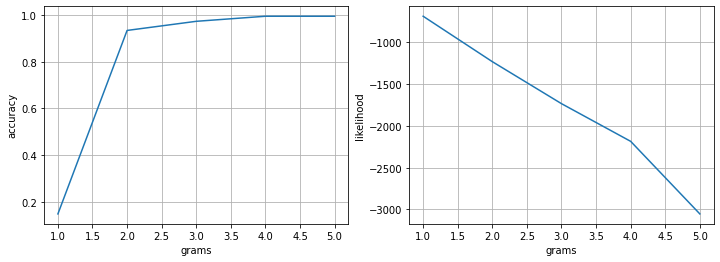

In [48]:
fig, axes2d = plt.subplots(1, 2, figsize=(12, 4))
for i, (graphs, name) in enumerate(zip([acc_result, likelihood], ['accuracy', 'likelihood'])):
    axes2d[i].plot(grams, graphs)
    axes2d[i].set_xlabel('grams')
    axes2d[i].set_ylabel(name)
    axes2d[i].grid(True)

#### 6. Какие вы можете придумать применения для этой модели?

Пришли в голову интересные идеи о том, что можно применить данную модель не только к символам, но и абстрактным сущностям. Например, чтобы построить матрицу соответсвия между эмбеддингами нейросети (трекинг, венгерский алгоритм, ф-ция стоимости - эвклидово расстояние, соответсвие между объектами кадр назад и текущими)